This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [26]:
import numpy as np
import dendropy
from dendropy.calculate import treecompare
import warnings
import matplotlib.pyplot as plt

import json
import os
from matplotlib.patches import Patch

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
from sklearn.metrics import adjusted_rand_score

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, mut_count_distance

In [27]:
path = r"D:\PhD\SCITERNA\simulated_data" #../data/simulated_data"
path_consensus = "../data/results"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = ["", "5", "10", "20"]

n_round = 1

config = load_config_and_set_random_seed()

use_summary_statistics = False # Uses the summary files saved in the data_summary/ directory. If raw output files were generated, set to False
# genotype_differences = {"SCITE-RNA": {}}
# path_len_differences = {"SCITE-RNA": {}}
# mut_count_differences = {"SCITE-RNA": {}}
# rf_differences = {"SCITE-RNA": {}}
# quartet_differences = {"SCITE-RNA": {}}
#
# genotype_differences["SCITE-RNA-clustered"] = {}
# path_len_differences["SCITE-RNA-clustered"] = {}
# mut_count_differences["SCITE-RNA-clustered"] = {}
# adjusted_rand_index= {"SCITE-RNA-clustered": {}}
# rf_differences["SCITE-RNA-clustered"] = {}
# quartet_differences["SCITE-RNA-clustered"] = {}
#
# path_len_differences["SCITE-RNA-consensus"] = {}
#
# genotype_differences["SClineager"] = {}
# path_len_differences["SClineager"] = {}
# mut_count_differences["SClineager"] = {}
# adjusted_rand_index["SClineager"] = {}
# rf_differences["SClineager"] = {}
# quartet_differences["SClineager"] = {}
#
# genotype_differences["DENDRO"] = {}
# path_len_differences["DENDRO"] = {}
# mut_count_differences["DENDRO"] = {}
# adjusted_rand_index["DENDRO"] = {}
# rf_differences["DENDRO"] = {}
# quartet_differences["DENDRO"] = {}
#
# genotype_differences["PhylinSic"] = {}
# path_len_differences["PhylinSic"] = {}
# mut_count_differences["PhylinSic"] = {}
# rf_differences["PhylinSic"] = {}
# quartet_differences["PhylinSic"] = {}


models = [
    "SCITE-RNA",
    "SCITE-RNA-clustered",
    "SCITE-RNA-consensus",
    "SClineager",
    "DENDRO",
    "PhylinSic"
]

# Initialize all metrics as empty dictionaries
genotype_differences = {}
path_len_differences = {}
mut_count_differences = {}
rf_differences = {}
quartet_differences = {}
adjusted_rand_index = {}

# List of metrics
metrics = [genotype_differences, path_len_differences, mut_count_differences, rf_differences, quartet_differences,adjusted_rand_index]

# Add each model as a key with an empty dictionary as the value for each metric
for metric in metrics:
    for model in models:
        metric[model] = {}

In [28]:
import itertools

def normalize_split(split):
    A, B = map(set, split)

    # Remove trivial splits (less than 2 leaves on either side)
    if len(A) < 2 or len(B) < 2:
        return None

    # Create frozensets for each side
    side1 = frozenset(A)
    side2 = frozenset(B)

    # Return a canonical bipartition as frozenset of frozensets (order insensitive)
    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

def get_normalized_splits_set(ct):
    """
    Return a set of canonical splits for internal edges of ct.
    Each split is represented as a frozenset([frozenset(side1), frozenset(side2)]).
    Uses the same normalization as your normalize_split function.
    """
    labels = list(ct.leaves(ct.main_root))
    splits_raw = get_splits(ct, ct.main_root, labels)
    splits = set()
    for split in splits_raw:
        norm = normalize_split(split)
        if norm is not None:
            # convert leaf labels to ints if necessary
            # (normalize_split already used sets of labels as returned by ct.leaves)
            splits.add(norm)
    return splits

def quartet_topology_from_splits(splits_set, quartet):
    """
    Given `splits_set` (set of canonical bipartitions) and a quartet (iterable of 4 leaf labels),
    return the quartet topology as a canonical frozenset of two frozensets (pairings).
    Returns None if quartet is unresolved (no split divides it 2-2).
    """
    qset = set(quartet)
    for split in splits_set:
        # split is frozenset([frozenset(side1), frozenset(side2)])
        side1, side2 = tuple(split)
        # they are frozensets; compute intersection size with quartet
        inter1 = set(side1) & qset
        inter2 = set(side2) & qset
        if len(inter1) == 2 and len(inter2) == 2:
            part1 = frozenset(inter1)
            part2 = frozenset(inter2)
            # canonical representation (order-insensitive)
            return frozenset([part1, part2])
    return None

def quartet_distance_by_enumeration(ct1, ct2):
    """
    Compute quartet distance between two CellTree objects by enumeration.
    Returns the number of discordant quartets (an integer).
    """
    labels = list(ct1.leaves(ct1.main_root))
    n = len(labels)
    if n < 4:
        return 0

    splits1 = get_normalized_splits_set(ct1)
    splits2 = get_normalized_splits_set(ct2)

    discordant = 0
    # iterate over all quartets
    for quartet in itertools.combinations(labels, 4):
        topo1 = quartet_topology_from_splits(splits1, quartet)
        topo2 = quartet_topology_from_splits(splits2, quartet)

        # Concordant if both resolved and identical, or both unresolved (None == None).
        # Discordant otherwise (one resolved and the other not; or both resolved but different).
        if topo1 == topo2:
            continue
        else:
            discordant += 1

    return discordant

def normalized_quartet_distance(ct1, ct2):
    """
    Returns quartet distance normalized to [0,1].
    """
    labels = list(ct1.leaves(ct1.main_root))
    n = len(labels)
    tot_quartets = (n * (n-1) * (n-2) * (n-3)) // 24  # C(n,4)
    if tot_quartets == 0:
        return 0.0
    qdist = quartet_distance_by_enumeration(ct1, ct2)
    return qdist / tot_quartets


def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [29]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):

        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []
            quartet_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))
                # quartet_distances.append(quartet_distance_by_enumeration(ct_gt, ct_sciterna))

            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = vaf_differences
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = rf_distances
            # quartet_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = quartet_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")
            # print(np.nanmean(quartet_distances), " mean quartet distance")

2.3880163265306122  mean path length distance
0.030648000000000005  mean abs difference of vafs predicted
11.563787755102041  mean mutation count distance
75.68  mean Robinson-Foulds distance
4.887208163265306  mean path length distance
0.034108999999999993  mean abs difference of vafs predicted
40.69462040816327  mean mutation count distance
84.52  mean Robinson-Foulds distance
3.6361714285714286  mean path length distance
0.0327506  mean abs difference of vafs predicted
28.118571428571418  mean mutation count distance
75.68  mean Robinson-Foulds distance
2.4828979591836733  mean path length distance
0.03191580000000001  mean abs difference of vafs predicted
22.624220408163268  mean mutation count distance
64.84  mean Robinson-Foulds distance


In [30]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            path_len_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                base_path_consensus = os.path.join(path_consensus, f"{n_c}c{n_m}m{clone}")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path_consensus,  "sciterna_consensus_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

            path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = path_len_distances
            print(np.mean(path_len_distances), " mean path length distance")

2.2206367346938776  mean path length distance
4.076481632653061  mean path length distance
3.384653061224489  mean path length distance
2.4992897959183673  mean path length distance


In [31]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0675508  mean abs difference of vafs predicted
3.5893877551020403  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
0.0501416  mean abs difference of vafs predicted
4.209836734693877  mean path length distance
4.876157835671342  mean mutation count distance
0.4864087198943913  mean adjusted rand index
0.0794224  mean abs difference of vafs predicted
3.9233632653061226  mean path length distance
6.325736032064131  mean mutation count distance
0.448898661930177  mean adjusted rand index
0.09255079999999999  mean abs difference of vafs predicted
3.5360244897959183  mean path length distance
6.191681042084168  mean mutation count distance
0.4214693242006576  mean adjusted rand index


In [32]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        path_len_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)
                genotype_predicted = vectorized_map(genotype_predicted)

                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_phylinsic = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_phylinsic))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")

0.09176639999999998  mean abs difference of vafs predicted
4.879518367346939  mean path length distance
5.798757034068137  mean mutation count distance
0.11988019999999999  mean abs difference of vafs predicted
5.566334693877551  mean path length distance
6.185779318637275  mean mutation count distance
0.11947959999999998  mean abs difference of vafs predicted
5.442571428571429  mean path length distance
6.103814749499  mean mutation count distance
0.12024799999999997  mean abs difference of vafs predicted
5.2976  mean path length distance
6.051564408817637  mean mutation count distance


In [33]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)

                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue
                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

Cells or mutations were filtered out
Cells or mutations were filtered out
0.06797775510204082  mean abs difference of vafs predicted
4.651453561016242  mean path length distance
4.988632775755593  mean mutation count distance
1.0  mean adjusted rand index
0.08357539999999998  mean abs difference of vafs predicted
4.515102040816327  mean path length distance
6.251465571142286  mean mutation count distance
0.32879471421472906  mean adjusted rand index
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08701958762886597  mean abs difference of vafs predicted
4.575821586366505  mean path length distance
5.9921693283474164  mean mutation count distance
0.16775850098537823  mean adjusted rand index
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08818346938775509  mean abs difference of vafs predicted
4.443631820074968  mean path length distance
5.905128951781113  mean mutation count distance
0.08625234

In [34]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_dendro = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_dendro.use_parent_vec(dendro_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")

0.0675508  mean abs difference of vafs predicted
4.732391836734695  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
0.0751738  mean abs difference of vafs predicted
4.659591836734694  mean path length distance
5.61423254509018  mean mutation count distance
0.23567379134374583  mean adjusted rand index
0.10883880000000003  mean abs difference of vafs predicted
4.6629632653061215  mean path length distance
6.6394586773547095  mean mutation count distance
0.09482540200326817  mean adjusted rand index
0.11349439999999998  mean abs difference of vafs predicted
4.608440816326531  mean path length distance
6.325874789579157  mean mutation count distance
0.05038498739179565  mean adjusted rand index


In [35]:
if use_summary_statistics:
    with open("../data_summary/simulated_data/genotype_differences.json", "r") as f:
        genotype_differences = json.load(f)
    with open("../data_summary/simulated_data/path_len_differences.json", "r") as f:
        path_len_differences = json.load(f)
    with open("../data_summary/simulated_data/adjusted_rand_index.json", "r") as f:
        adjusted_rand_index = json.load(f)
    with open("../data_summary/simulated_data/runtimes.json", "r") as f:
        runtime_data = json.load(f)

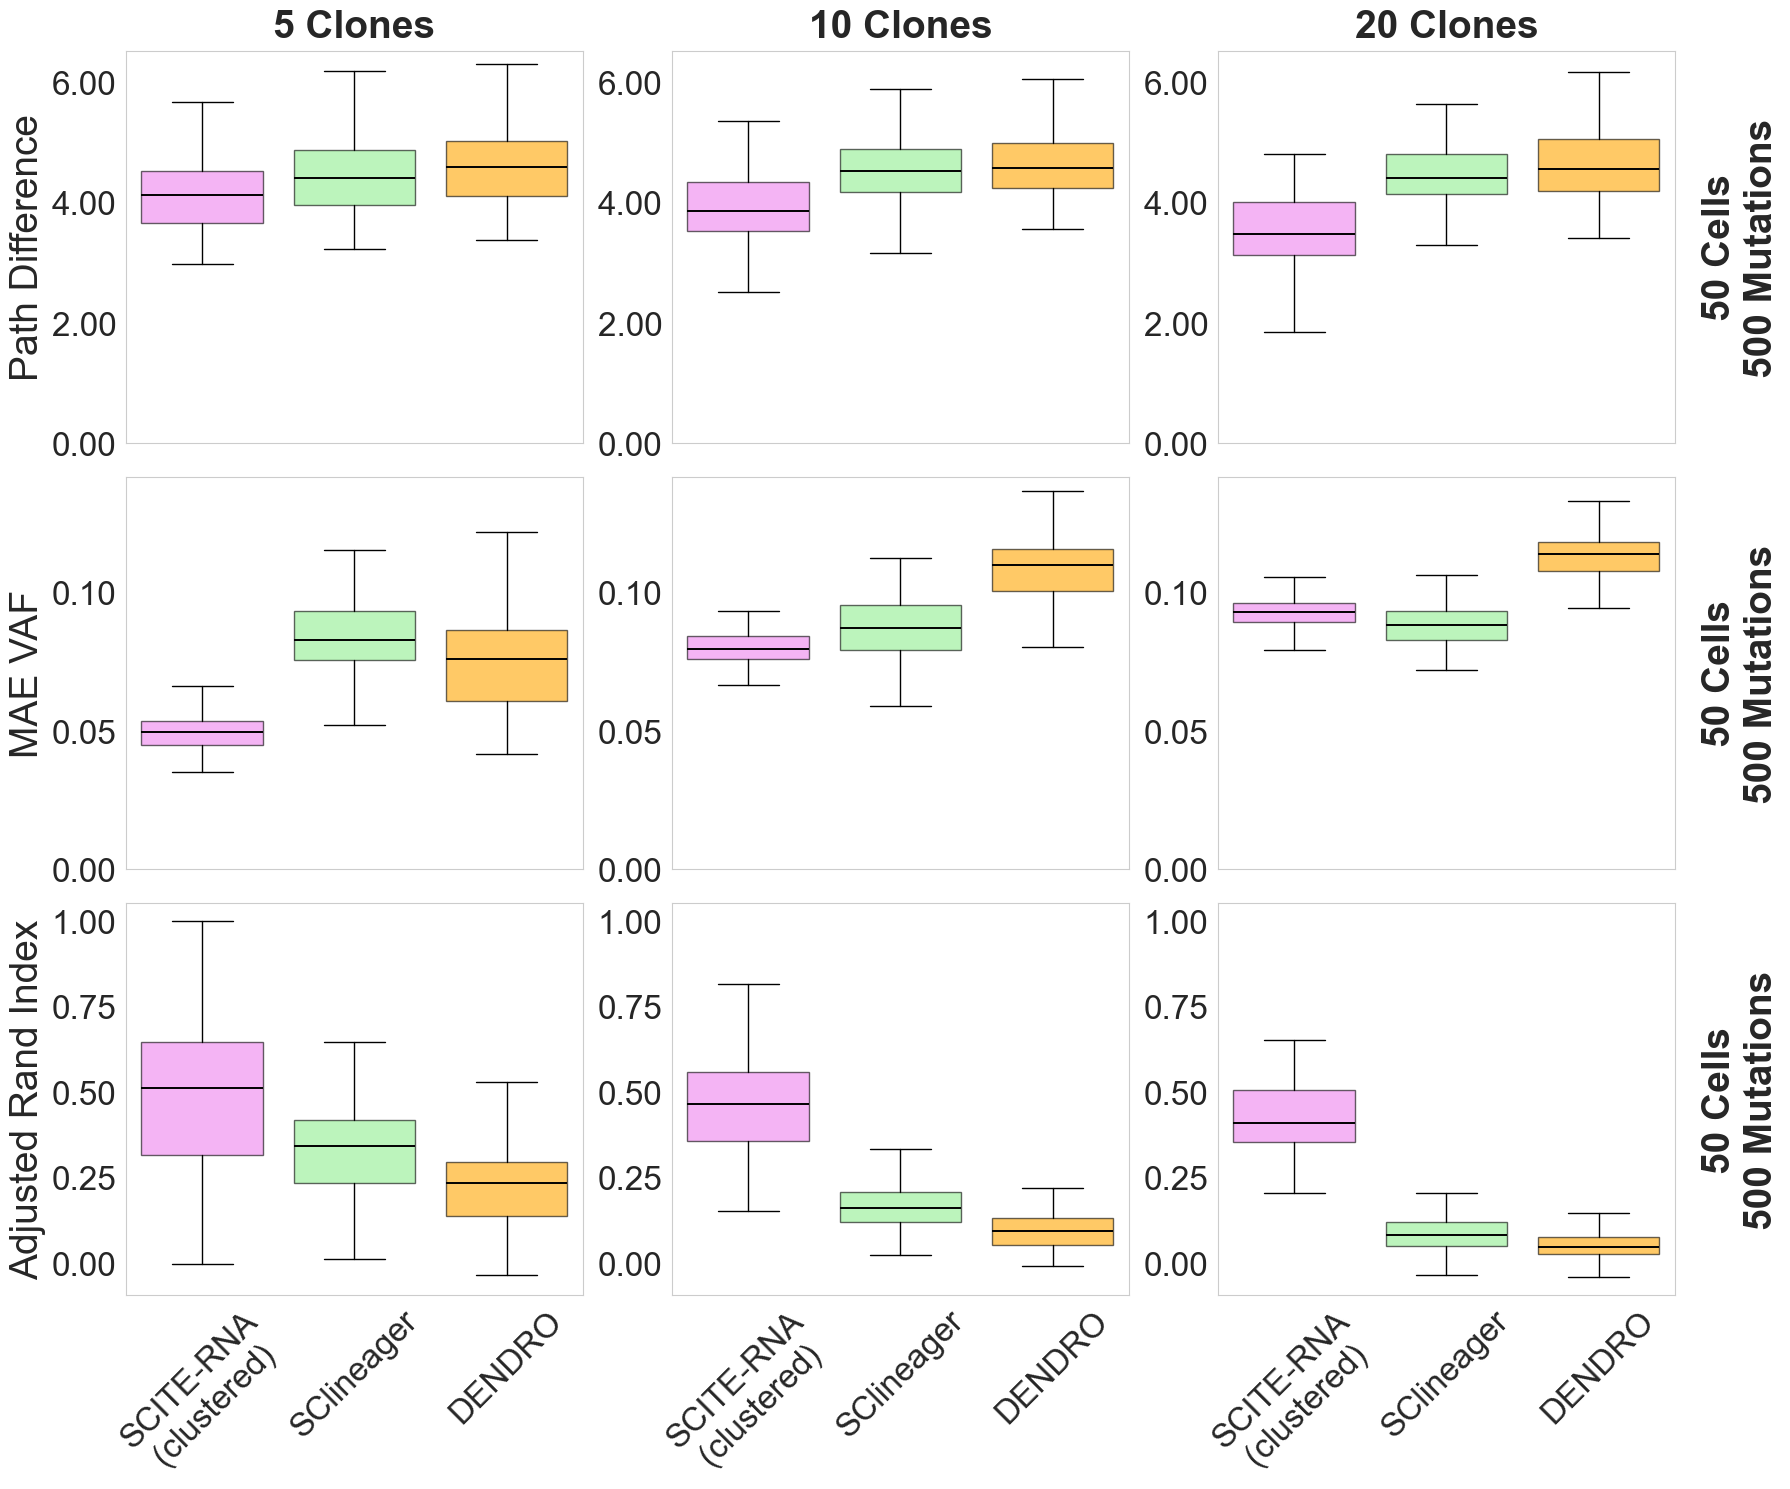

In [36]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, ari_data, clones, models=["SCITE-RNA-clustered", "SClineager", "DENDRO"]):

    n_c, n_m = 50, 500
    rows = 3
    cols = len(clones)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=False)

    if rows == 1 or cols == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["violet", "lightgreen", "orange"]
    alpha_value = 0.6
    title_size = 28
    label_size = 28
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8
    plot_titles = ["Path Difference", "MAE VAF", "Adjusted Rand Index"]
    data_list = [pathlen_data, vaf_data, ari_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []
        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            ax = axes[row_idx, col_idx]

            all_samples = [data[model][sample_key][clone] for model in models]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            # Set titles on the top row
            if row_idx == 0:
                ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                custom_labels = [
                    "SCITE-RNA\n(clustered)",
                    "SClineager",
                    "DENDRO"
                ]
                ax.set_xticks(range(1, len(models) + 1))
                ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=90, ha='center', va='top')
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)

            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            ymin, ymax = combined.min(), combined.max()
            yrange = ymax - ymin
            ymin = min(ymin - 0.05 * yrange, 0)
            ymax += 0.05 * yrange
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_clustering_Path_VAF_ARI.pdf")
    plt.show()

plot_combined_vaf_pathlength(
    path_len_differences,
    genotype_differences,
    adjusted_rand_index,
    ["5", "10", "20"]
)

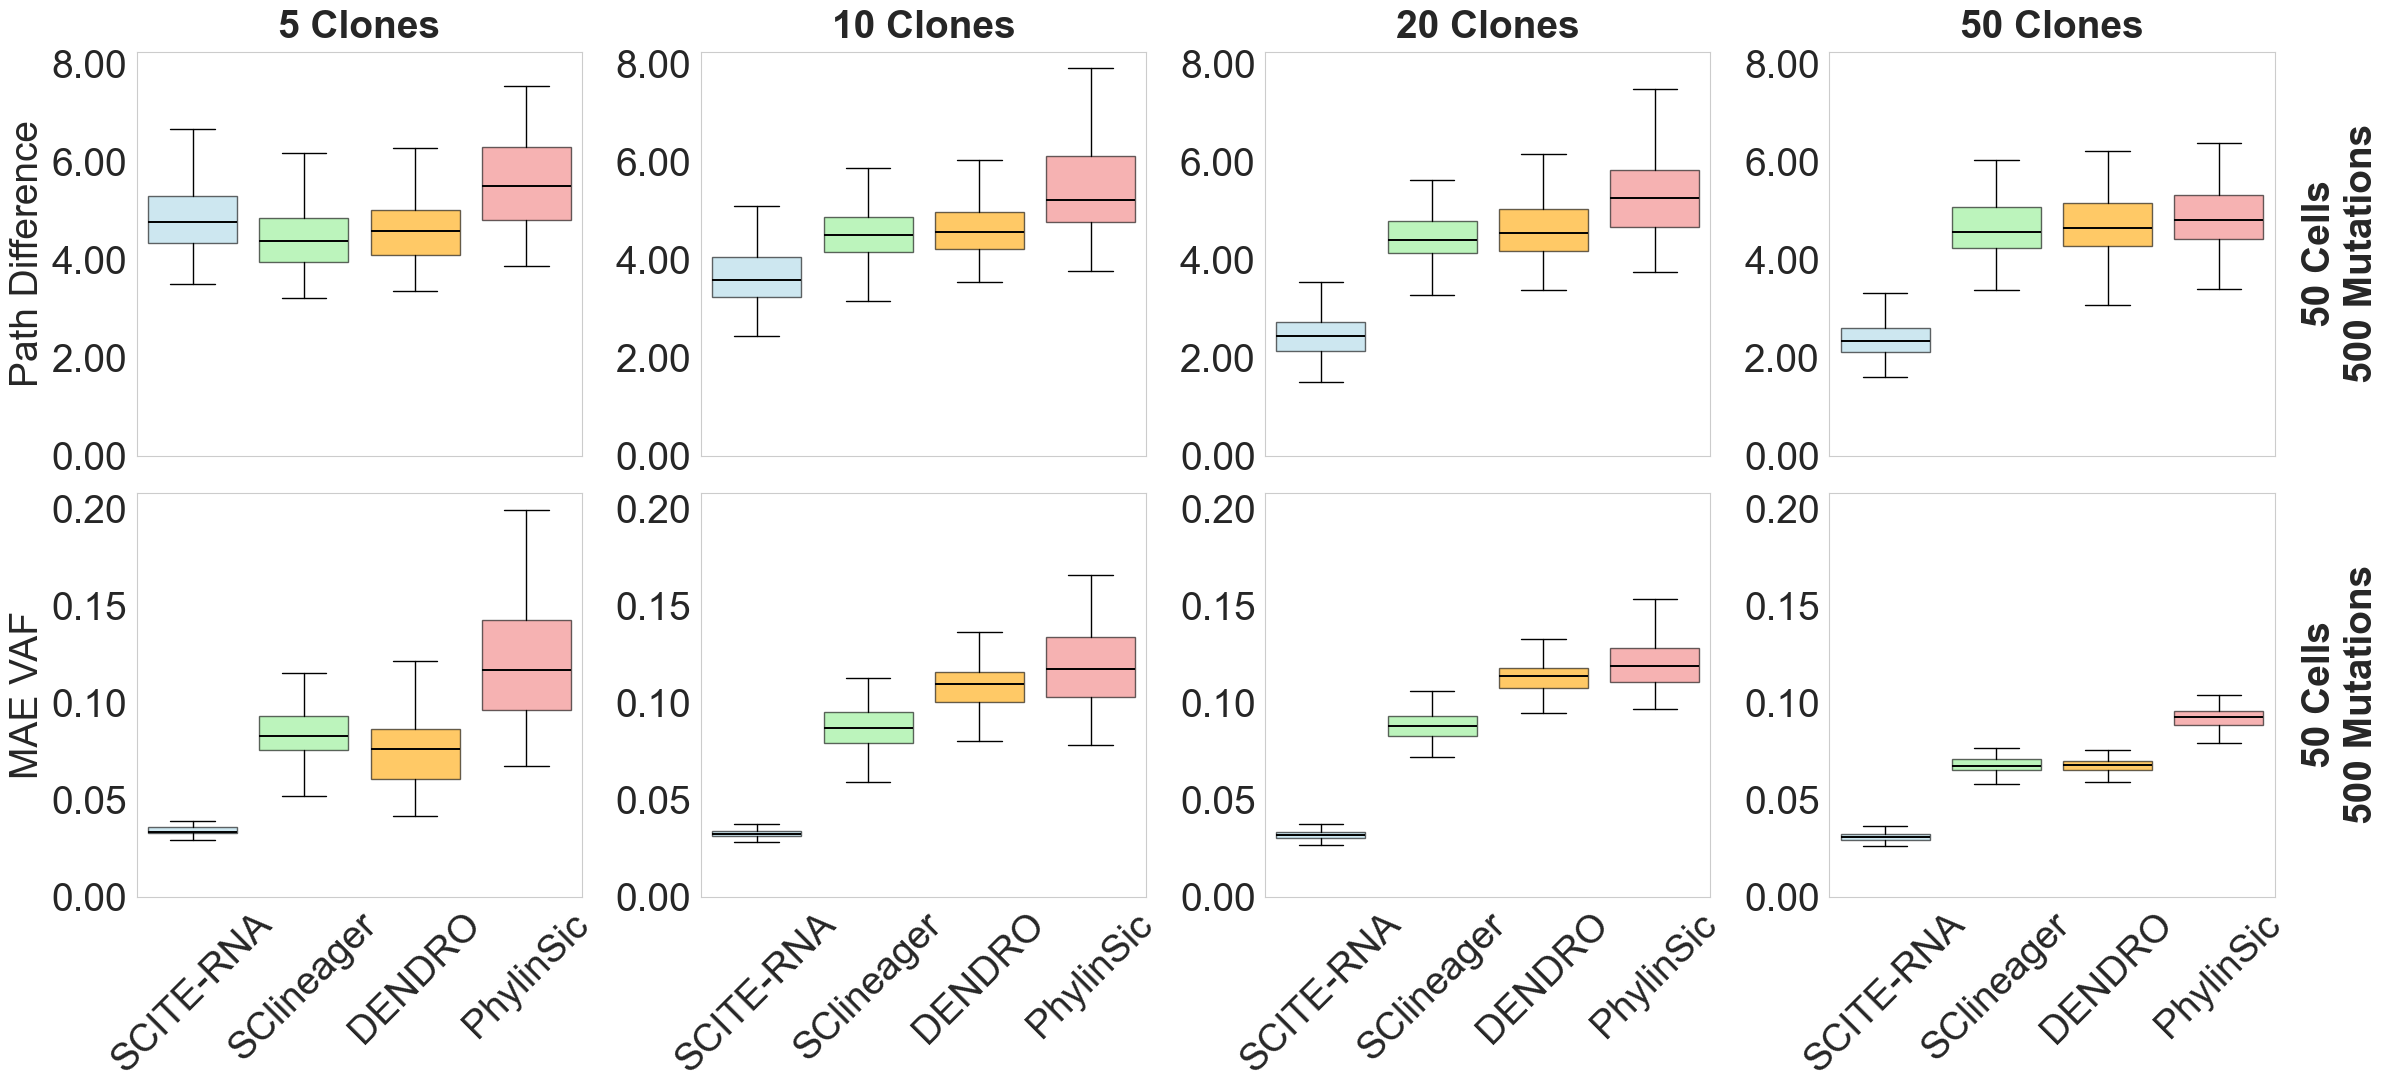

In [37]:
def plot_combined_vaf_pathlength(pathlen_data, vaf_data, clones, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = 2
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Difference", "MAE VAF"]
    data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_Path_VAF.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, genotype_differences, ["5", "10", "20", ""])

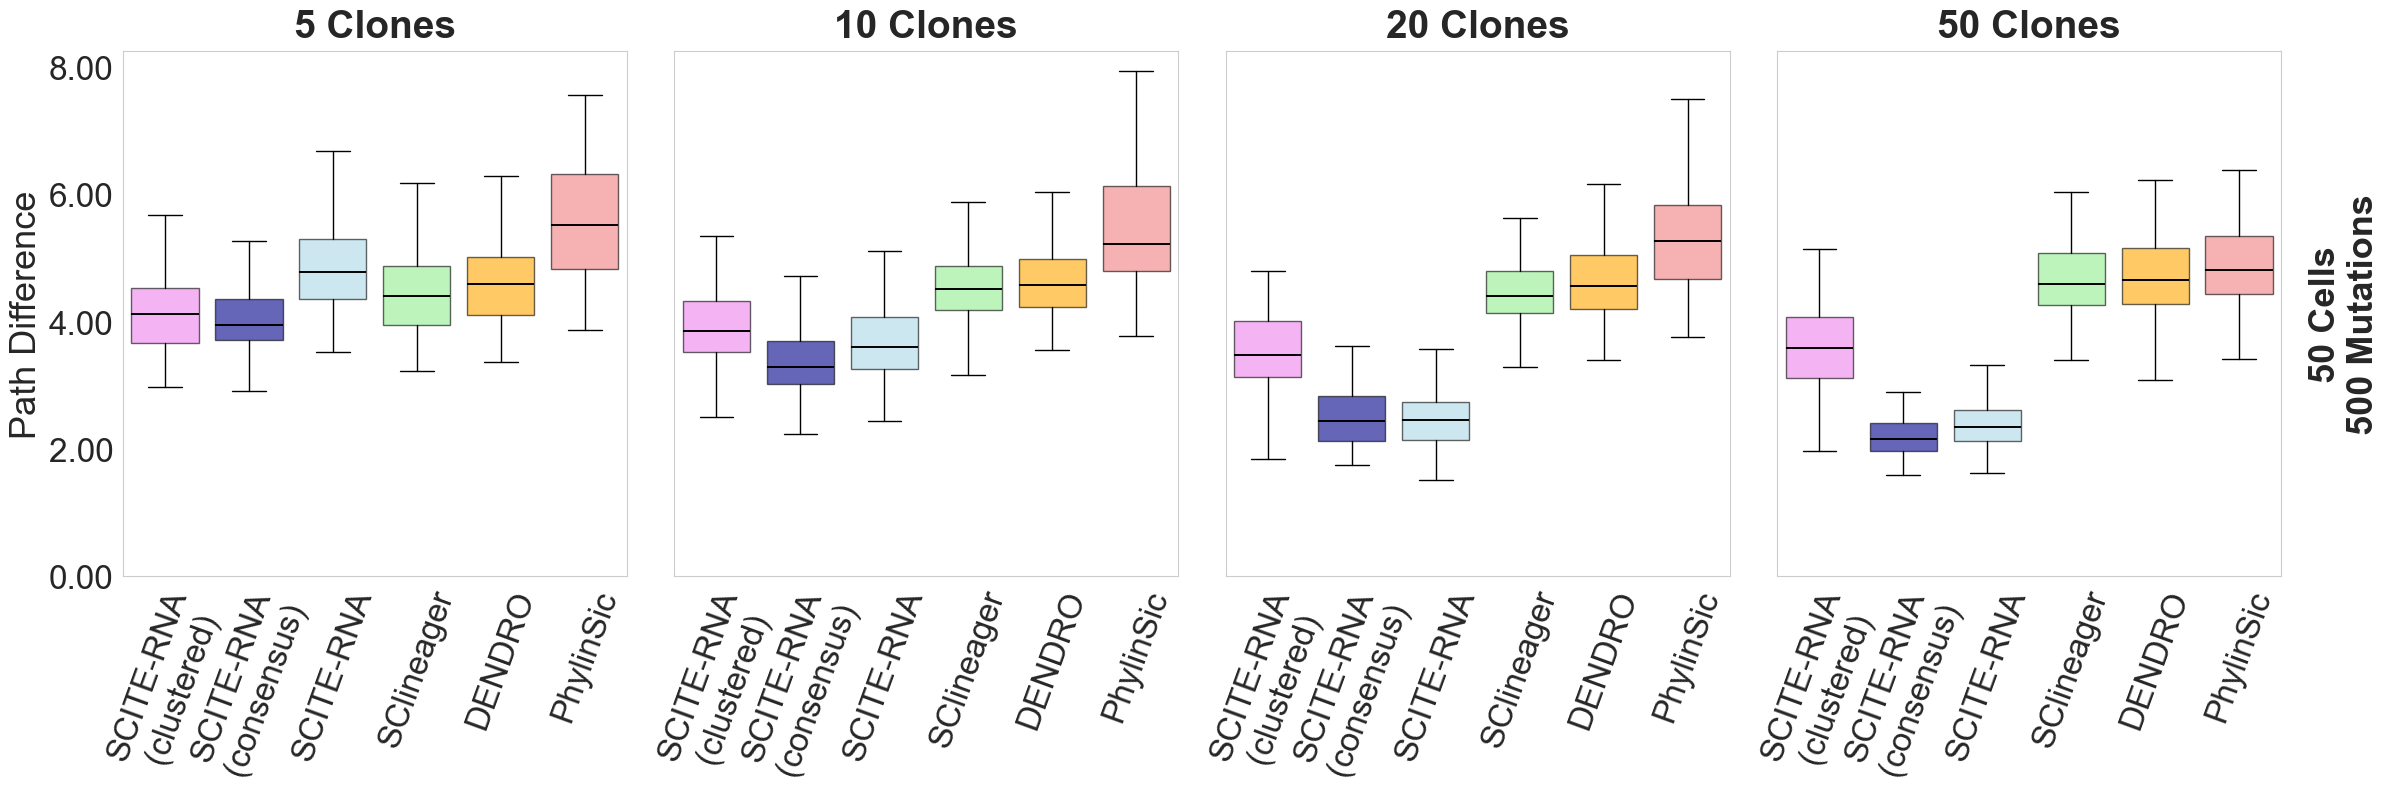

In [38]:
def plot_combined_vaf_pathlength(pathlen_data, clones, models=["SCITE-RNA-clustered", "SCITE-RNA-consensus", "SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):
    n_c, n_m = 50, 500
    cols = len(clones)
    fig, axes = plt.subplots(1, cols, figsize=(6 * cols, 8), sharey=True)
    if cols == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["violet", "darkblue", "lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6
    title_size = 28
    label_size = 26
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8

    row_whiskers = []

    for col_idx, clone in enumerate(clones):
        sample_key = f"{n_c}_{n_m}"
        all_samples = [pathlen_data[model][sample_key][clone] for model in models]
        ax = axes[col_idx]

        # Plot boxplots
        box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha_value)

        for line in box['medians']:
            line.set_linewidth(box_width)
            line.set_color("black")

        whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
        row_whiskers.append(whisker_data)

        custom_labels = [
            "SCITE-RNA\n(clustered)",
            "SCITE-RNA\n(consensus)",
            "SCITE-RNA",
            "SClineager",
            "DENDRO",
            "PhylinSic"
        ]

        ax.set_xticks(range(1, len(models) + 1))
        ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=70, ha='center', va='top')

        if clone == "":
            ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
        else:
            ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid(False)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Add y-axis label only to the first subplot
        if col_idx == 0:
            ax.set_ylabel("Path Difference", fontsize=label_size)

        # Add cell/mutation info to the last subplot
        if col_idx == cols - 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                          fontsize=label_size,
                          rotation=90, labelpad=20,
                          fontproperties=FontProperties(weight='bold'))

    # uniform y-axis limits
    combined = np.concatenate(row_whiskers)
    ymin, ymax = combined.min(), combined.max()
    yrange = ymax - ymin
    ymin = 0
    ymax += 0.05 * yrange

    for col_idx in range(cols):
        axes[col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_clustering_consensus_Path.pdf")
    plt.show()

plot_combined_vaf_pathlength(path_len_differences, ["5", "10", "20", ""])

Error loading data for 50c 50m: ../data/simulated_data/50c50m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 50c 100m: ../data/simulated_data/50c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 50m: ../data/simulated_data/100c50m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 100m: ../data/simulated_data/100c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 200m: ../data/simulated_data/100c200m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 200c 100m: ../data/simulated_data/200c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 200c 200m: ../data/simulated_data/200c200m\sciterna\sciterna_runtimes.txt not found.


IndexError: list index out of range

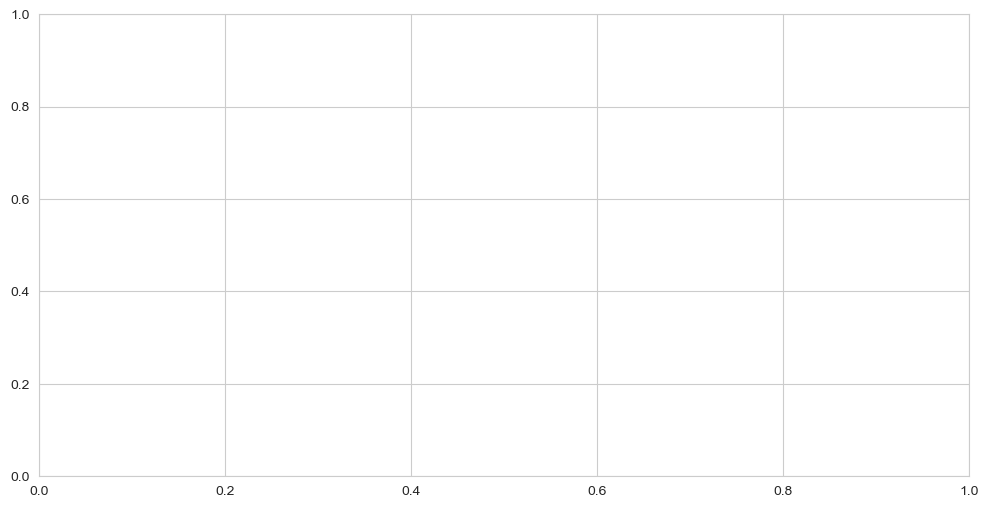

In [39]:
n_cells = [50, 50, 100, 100, 100, 200, 200]
n_mut = [50, 100, 50, 100, 200, 100, 200]
path = "../data/simulated_data/"
clone = ""

models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

conditions = []
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

if not use_summary_statistics:
    runtime_data = {model: [] for model in models}
    for n_c, n_m in zip(n_cells, n_mut):
        condition_label = f"{n_c}c {n_m}m"

        base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
        try:
            scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
            sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
            dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
        except Exception as e:
            print(f"Error loading data for {condition_label}: {e}")
            continue

        runtime_data["SCITE-RNA"].append(scite_rna)
        runtime_data["SClineager"].append(sclineager)
        runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.7)

for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(1.0)

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=12)
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=12, color='gray', zorder=1)

legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig("../data/results/figures/Figure_model_runtime_comparison.pdf")
plt.show()